In [1]:
import pandas as pd
import json, sys, os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MONTH_MAP = dict(zip(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

Format for rates:  
```
rate_prices = {
    "A": { # Off-peak
        "from_grid": 0.10628,
        "to_grid": [-0.10628,-0.03162]
    },
    "B": { # On-peak
        "from_grid": 0.23382,
        "to_grid": [-0.23382,-0.06070]
    }
```

# NEM 3.0 with E-ELEC Rate Schedule

In [3]:
NEM3_Export = pd.read_csv("../Project_data/Energy_Rates/NEM 3.0/PGE-Solar-Billing-Plan-Export-Rates-2023/PG&E NBT EEC Values Floating Vintage.csv")

In [4]:
# Filter only one year's worth of dates
NEM3_Export = NEM3_Export[(pd.to_datetime(NEM3_Export['DateStart']) >= '2024-01-01') & (pd.to_datetime(NEM3_Export['DateStart']) < '2025-01-01')]
# Filter out the Generation Export Rates
NEM3_Export = NEM3_Export[NEM3_Export['RIN'] == "USCA-XXPG-NB00-0000"]

In [5]:
export_rates = NEM3_Export.groupby('ValueName').min()['Value']

In [6]:
export_table = NEM3_Export.groupby('ValueName').min()[['Value']]
export_table[['Month', 'Day', 'Hour']] = export_table.index.to_series().str.split(" ", expand=True)
export_table['Hour'] = export_table['Hour'].str.replace("HS","").astype(int)
export_table['Month'] = export_table['Month'].map({v:k for k, v in MONTH_MAP.items()})

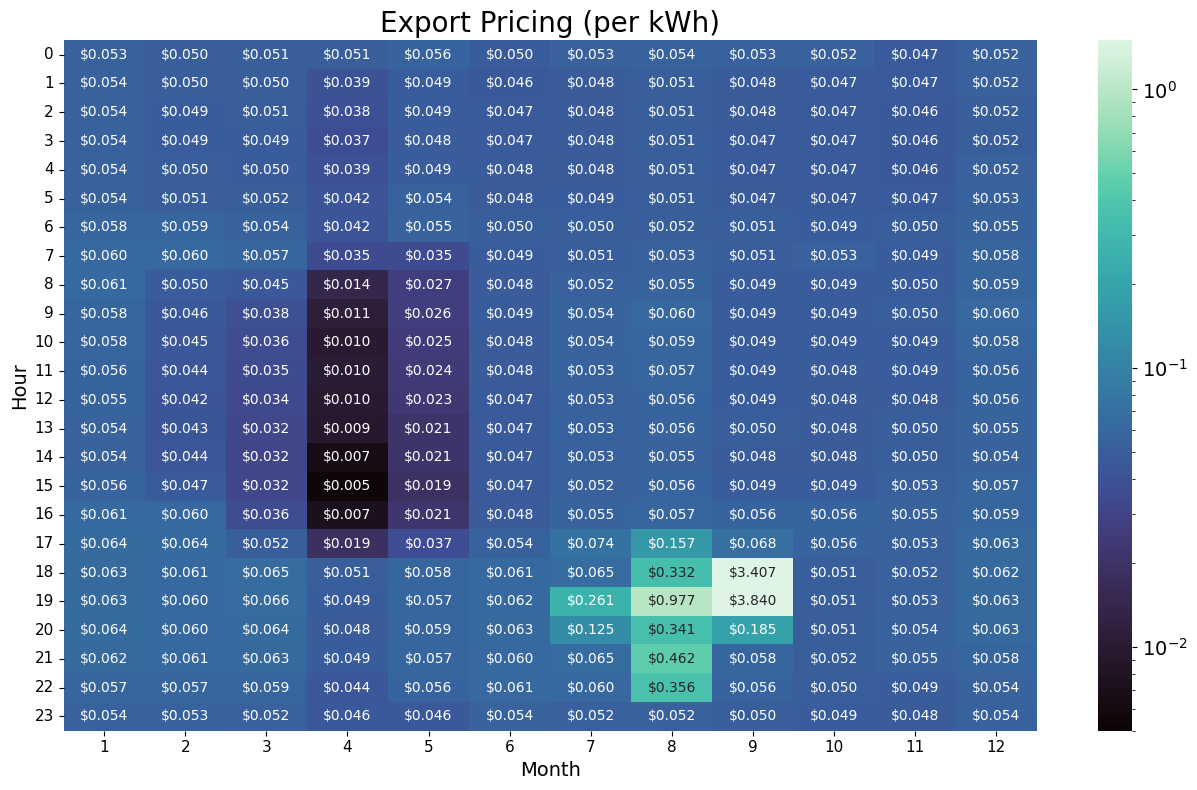

In [36]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
fontsize=14
plt.figure(figsize=(13,8))
weekdays = export_table[export_table['Day'] == 'Weekday'].pivot_table("Value", index="Hour", columns="Month")
weekdays_label = [[f'${v:.3f}' for v in weekdays.iloc[x, :]] for x in range(len(weekdays))]
ax = sns.heatmap(weekdays, annot=weekdays_label, fmt="s", norm=LogNorm(vmin=0.005, vmax=1.5), cmap="mako")
ax.figure.axes[-1].tick_params(labelsize=fontsize)
plt.title("Export Pricing (per kWh)", fontsize=20)
ax.xaxis.label.set_size(fontsize)
ax.yaxis.label.set_size(fontsize)

plt.xticks(fontsize=fontsize-3)
plt.yticks(fontsize=fontsize-3, rotation=0)
plt.tight_layout()
plt.savefig("../figures/NEM3_Export_Pricing.pdf")

In [8]:
df = pd.read_csv("../Project_data/Normalized Data/sunnyvale_generation_hourly_2018.csv", index_col=0, parse_dates=True)
load = pd.read_csv("../Project_data/Normalized Data/sunnyvale_bid_367272_load_hourly_2018.csv", index_col=0, parse_dates=True)
df = df.merge(load, left_index=True, right_index=True)
df['month'] =                   pd.to_numeric(df.index.strftime('%-m'))
df['day'] =                     df.index.dayofyear
df['hour'] =                    pd.to_numeric(df.index.strftime("%-H"))

In [9]:
df['net energy'] = df['2018 Actual Meteorological Year Generation (kWh)'] - df['out.electricity.total.energy_consumption']

<Axes: xlabel='hour', ylabel='2018 Actual Meteorological Year Generation (kWh)'>

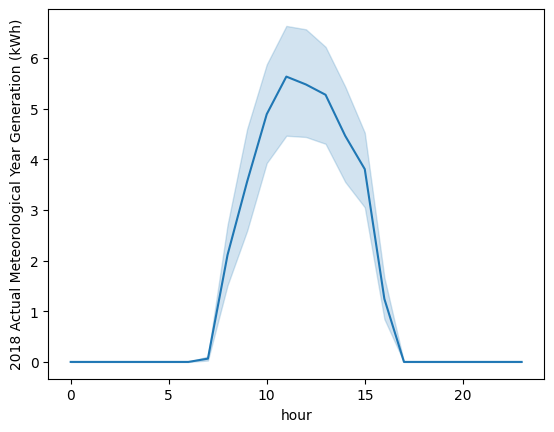

In [10]:
sns.lineplot(df[df.month == 1], x="hour", y="2018 Actual Meteorological Year Generation (kWh)")

<Axes: xlabel='hour', ylabel='net energy'>

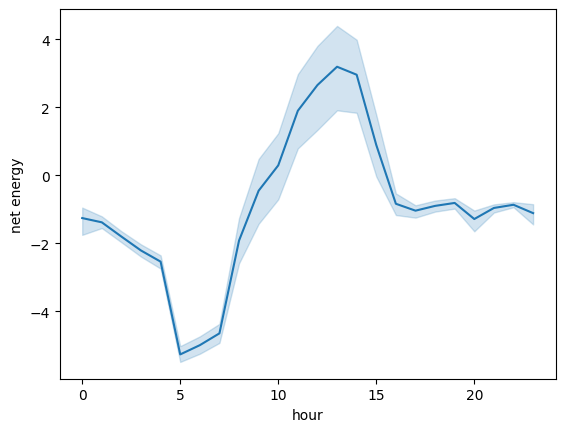

In [11]:
sns.lineplot(df[df.month == 12], x="hour", y="net energy")

Text(0.5, 1.0, 'Generation')

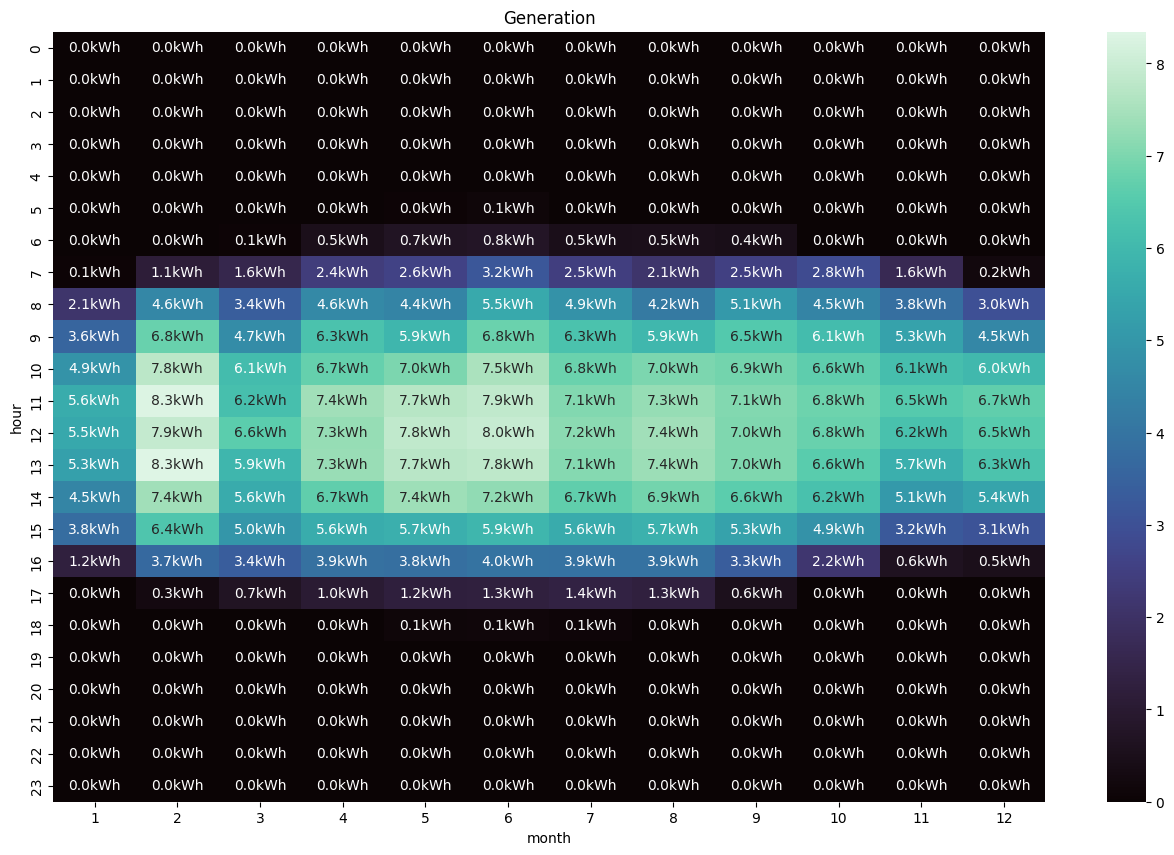

In [12]:

plt.figure(figsize=(16,10))
average_gen = df.pivot_table("2018 Actual Meteorological Year Generation (kWh)", index="hour", columns="month", aggfunc="mean")
gen_label = [[f'{v:.1f}kWh' for v in average_gen.iloc[x, :]] for x in range(len(average_gen))]
sns.heatmap(average_gen, annot=gen_label, fmt="s", cmap="mako")
plt.title("Generation")

Text(0.5, 1.0, 'Generation')

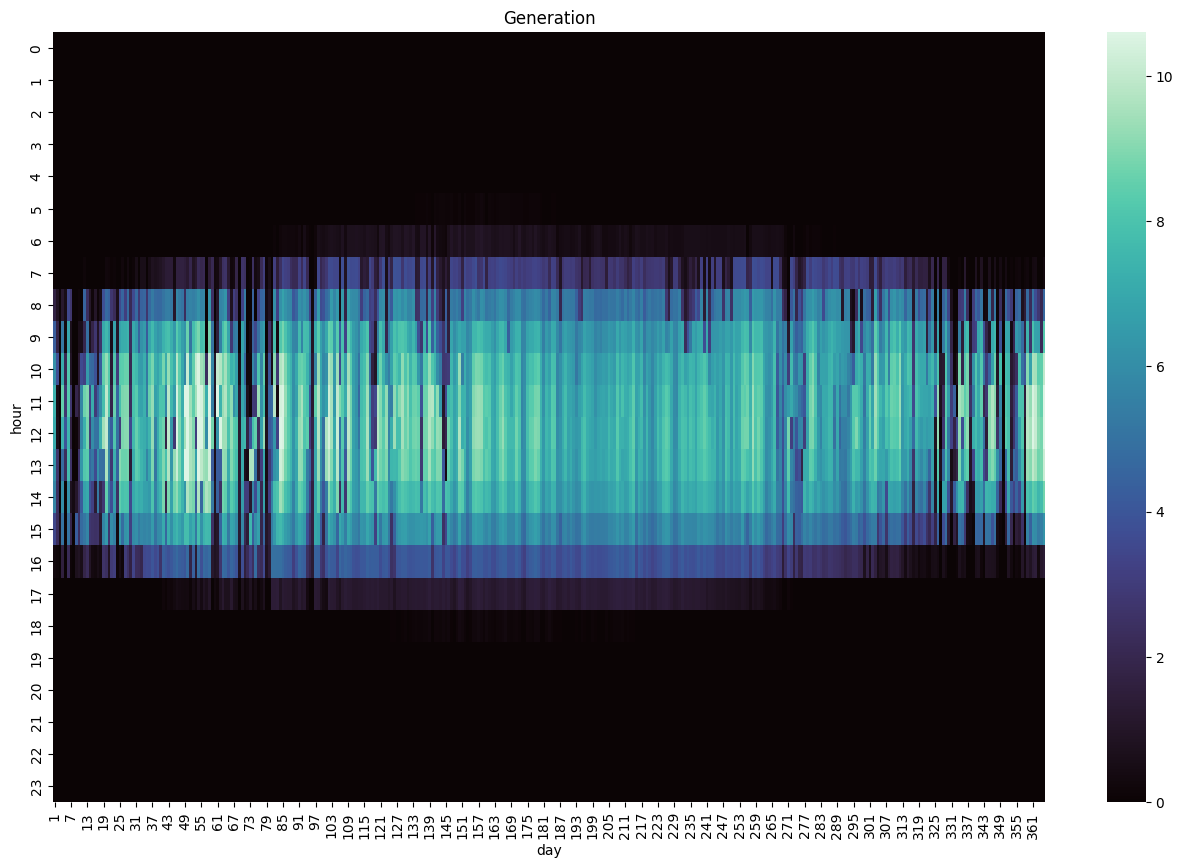

In [13]:

plt.figure(figsize=(16,10))
daily_gen = df.pivot_table("2018 Actual Meteorological Year Generation (kWh)", index="hour", columns="day", aggfunc="mean")
sns.heatmap(daily_gen, cmap="mako")
plt.title("Generation")

## E-ELEC Rate Schedule
Summer: Jun-Sept  
Winter: Oct-May

```
Peak:         4:00 p.m. to 9:00 p.m. every day including weekends and holidays.  
Partial-Peak: 3:00 p.m. to 4:00 p.m. and 9:00 p.m. to 12:00 a.m. every day including weekends and holidays.  
Off-Peak:     All other hours.  
```

In [14]:
import_rates = {
    "Summer": {
        "Peak": 0.63702,
        "Partial-Peak": 0.47514,
        "Off-Peak": 0.41846
    },
    "Winter": {
        "Peak": 0.40551,
        "Partial-Peak": 0.38342,
        "Off-Peak": 0.36956
    }
}

# Number in ValueName is the start time of the rate
hours = {
    0: "Off-Peak",
    1: "Off-Peak",
    2: "Off-Peak",
    3: "Off-Peak",
    4: "Off-Peak",
    5: "Off-Peak",
    6: "Off-Peak",
    7: "Off-Peak",
    8: "Off-Peak",
    9: "Off-Peak",
    10: "Off-Peak",
    11: "Off-Peak",
    12: "Off-Peak",
    13: "Off-Peak",
    14: "Off-Peak",
    15: "Partial-Peak",
    16: "Peak",
    17: "Peak",
    18: "Peak",
    19: "Peak",
    20: "Peak",
    21: "Partial-Peak",
    22: "Partial-Peak",
    23: "Partial-Peak"
}


In [15]:
rate_prices = {}
for rate_cat, export in export_rates.items():
    price = {}
    hour = float(rate_cat.split(' ')[2].replace("HS",""))
    if rate_cat.split(' ')[0] in ["Jun", "Jul", "Aug", "Sep"]:
        # Summer
        price["from_grid"] = import_rates['Summer'][hours[hour]]
    else:
        # Winter
        price["from_grid"] = import_rates['Winter'][hours[hour]]
    price['to_grid'] = (-export, -export)
    rate_prices[rate_cat] = price

In [16]:
rate_schedule = {}
for idx, month in MONTH_MAP.items():
    rate_schedule[str(idx)] = {
        "Weekday": [f"{month} Weekday HS{i}" for i in range(24)],
        "Weekend": [f"{month} Weekend HS{i}" for i in range(24)]
    }

In [17]:
with open("../Project_data/Energy_Rates/nem3.json", 'w') as f:
    json.dump(
        {"rate_schedule": rate_schedule,
        "rate_prices": rate_prices,
        "source_limit": False}, f, indent=2)

# NEM 2.0 with E-ELEC Rate Schedule

## E-ELEC Rate Schedule
Summer: Jun-Sept  
Winter: Oct-May

```
Peak:         4:00 p.m. to 9:00 p.m. every day including weekends and holidays.  
Partial-Peak: 3:00 p.m. to 4:00 p.m. and 9:00 p.m. to 12:00 a.m. every day including weekends and holidays.  
Off-Peak:     All other hours.  
```

In [18]:
import_rates = {
    "Summer": {
        "Peak": 0.63702,
        "Partial-Peak": 0.47514,
        "Off-Peak": 0.41846
    },
    "Winter": {
        "Peak": 0.40551,
        "Partial-Peak": 0.38342,
        "Off-Peak": 0.36956
    }
}

# Export Rates are the import rates minus non-bypassable charges
nbc_rates = {
    "Peak":         0.02727 - 0.00259 + 0.00101 + 0.00561,
    "Partial-Peak": 0.02727 - 0.00259 + 0.00101 + 0.00561,
    "Off-Peak":     0.02727 - 0.00259 + 0.00101 + 0.00561
}

export_rates = {
    "Summer": {
        "Peak": nbc_rates['Peak'] - 0.63702,
        "Partial-Peak": nbc_rates['Partial-Peak'] - 0.47514,
        "Off-Peak": nbc_rates['Off-Peak'] - 0.41846
    },
    "Winter": {
        "Peak": nbc_rates['Peak'] - 0.40551,
        "Partial-Peak": nbc_rates['Partial-Peak'] - 0.38342,
        "Off-Peak": nbc_rates['Off-Peak'] - 0.36956
    }
}

In [19]:
rate_prices = {}

for season in ["Summer", "Winter"]:
    for cat in ["Peak", "Partial-Peak", "Off-Peak"]:
        rate_prices[f"{season} {cat}"] = {
            'from_grid': import_rates[season][cat],
            'to_grid': (export_rates[season][cat],export_rates[season][cat])
        }

In [20]:
rate_schedule = {}
for idx, month in MONTH_MAP.items():
    if month in ["Jun", "Jul", "Aug", "Sep"]:
        rate_schedule[str(idx)] = {
            "Weekday": ["Summer Off-Peak"] * 15 +    # Midnight to 3pm
                       ["Summer Partial-Peak"] * 1 + # 3pm-4pm
                       ["Summer Peak"] * 5 +         # 4pm-9pm
                       ["Summer Partial-Peak"] * 3,  # 9pm-Midnight 
            "Weekend": ["Summer Off-Peak"] * 15 +    # Midnight to 3pm
                       ["Summer Partial-Peak"] * 1 + # 3pm-4pm
                       ["Summer Peak"] * 5 +         # 4pm-9pm
                       ["Summer Partial-Peak"] * 3,  # 9pm-Midnight 
        }
    else:
        rate_schedule[str(idx)] = {
            "Weekday": ["Winter Off-Peak"] * 15 +    # Midnight to 3pm
                       ["Winter Partial-Peak"] * 1 + # 3pm-4pm
                       ["Winter Peak"] * 5 +         # 4pm-9pm
                       ["Winter Partial-Peak"] * 3,  # 9pm-Midnight 
            "Weekend": ["Winter Off-Peak"] * 15 +    # Midnight to 3pm
                       ["Winter Partial-Peak"] * 1 + # 3pm-4pm
                       ["Winter Peak"] * 5 +         # 4pm-9pm
                       ["Winter Partial-Peak"] * 3,  # 9pm-Midnight 
        }

In [21]:
with open("../Project_data/Energy_Rates/nem2.json", 'w') as f:
    json.dump(
        {"rate_schedule": rate_schedule,
        "rate_prices": rate_prices,
        "source_limit": True}, f, indent=2)

# WE Energies

In [22]:

# Rate schedule
# Formatted as a weekly rate plan plus holiday
rate_schedule = {
    "Weekday": ["A"] * 7 + ["B"] * 12 + ["A"] * 5,
    "Weekend": ["A"] * 24
}

rate_schedule = {}
for idx, month in MONTH_MAP.items():
    if month in ["Jun", "Jul", "Aug", "Sep"]:
        rate_schedule[str(idx)] = {
            "Weekday": ["Summer Off-Peak"] * 7 +      # Midnight to 7am
                       ["Summer On-Peak"] * 12 +      # 7am to 7pm
                       ["Summer Off-Peak"] * 5,       # 7pm to Midnight 
            "Weekend": ["Summer Off-Peak"] * 24       # Weekends are all Off-Peak
        }
    else:
        rate_schedule[str(idx)] = {
            "Weekday": ["Non-Summer Off-Peak"] * 7 +      # Midnight to 7am
                       ["Non-Summer On-Peak"] * 12 +      # 7am to 7pm
                       ["Non-Summer Off-Peak"] * 5,       # 7pm to Midnight 
            "Weekend": ["Non-Summer Off-Peak"] * 24       # Weekends are all Off-Peak
        }

# Rate prices
# Price organization:
#   from_grid: <cost_to_buy_per_kwh>
#   to_grid: [<price_to_offset_per_kwh>, <price_to_sell_excess_per_kwh>]
# For the `to_grid` pricing, if the utility only does net metering until offset, <price_to_offset> 
#   should match the <cost_to_buy_per_kwh> and any production over the consumption for that rate 
#   category will be sold at <price_to_sell_excess>. If the utility does not cap net metering
#   or does net billing, <price_to_offset_per_kwh> and <price_to_sell_excess_per_kwh> should match

# Using WE Energies CGS NM tariff for excess generation
# https://www.we-energies.com/pdfs/etariffs/wisconsin/cgs-nm.pdf
# and Rg2 Time of Use Tariff:
# https://www.we-energies.com/services/time-of-use-wi

rate_prices = {
    "Summer Off-Peak": { 
        "from_grid": 0.10628,
        "to_grid": [-0.10628,-0.03162]
    }, 
    "Summer On-Peak": {
        "from_grid": 0.23382,
        "to_grid": [-0.23382,-0.06070]
    },
    "Non-Summer Off-Peak": {
        "from_grid": 0.10628,
        "to_grid": [-0.10628,-0.03102]
    }, 
    "Non-Summer On-Peak": {
        "from_grid": 0.23382,
        "to_grid": [-0.23382,-0.04320]
    }
}

In [23]:
with open("../Project_data/Energy_Rates/wi-cgs-nm.json", 'w') as f:
    json.dump(
        {"rate_schedule": rate_schedule,
        "rate_prices": rate_prices,
        "source_limit": True}, f, indent=2)